# ACT CW2 Q2

__Q2 Objective:__

Process dataset using a Neural Network.

__Overview__

We have a binary classification problem, so we are sorting data into one of two classes based on the input values.


__Workflow__

1. Load in and pre-process data
2. Build a neural network to suit your problem
3. Pick a loss function and optimiser
4. Build a training loop
5. Fit the model to the data and make a prediction
6. Evaluate the model
7. Improve through experimentation
8. Save and reload the trained model

### Import Libraries

In [226]:
# import necessary libraries

import numpy as np # numpy
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting
# integrate plots into notebook
%matplotlib inline

# import seaborn as sns # for data visualisation

# machine learning libraries

from sklearn.model_selection import train_test_split # splitting the dataset
from sklearn.preprocessing import StandardScaler # standardising features
from sklearn import metrics # for evaluating the NN

import torch # pytorch library
from torch.utils.data import TensorDataset, DataLoader # for batching data
from torch import nn, optim # neural networks and optimiser

### Set up GPU Support

If there is a GPU available for PyTorch to use, this will be much faster for running the neural network than using the CPU, as GPUs are much faster for executing matrix multiplication operations.

__Note:__ 

My computer's processor has an integrated graphics card and no dedicated GPU. The code cell below will return False and any code run on my personal computer will be run on the CPU, which may be slower or less efficient. 

However, I will still include the code cell below for cases when this code is run on a PC or Google Colab. If using Google Colab, go to Runtime > Change runtime type > Hardware accelerator > GPU.


In [227]:
# is there a GPU available?
gpu_TF = torch.cuda.is_available()

# print the result
print("GPU available:")
print(gpu_TF)

# if there is a GPU available

if gpu_TF == True:
    # there is a GPU available
    # set the device to the graphics processor
    device = torch.device("cuda")
else:
    # there is no GPU available
    # use the CPU instead
    device = torch.device("cpu")

# print the device we are using
print("\nDevice:")
print(device)

# we can now store tensors on the selected device using .to(device)
# and this will work for both cpu and gpu devices

GPU available:
False

Device:
cpu


### Set Random Seed

In [229]:
# set random seed at the top of the notebook
# so that all pseudorandomness is reproducible

# any integer
Q2_seed = 13

# set all random seeds here

np.random.seed(Q2_seed) # numpy
torch.manual_seed(Q2_seed) # pytorch cpu
torch.cuda.manual_seed(Q2_seed) # pytorch gpu

## 
> ## Preparing the Dataset

### Load in the Dataset

Load in the data file (currently in csv file), add the data to a pandas dataframe, and inspect the dataframe to check that it has loaded in correctly.

In [151]:
# import the data file
# data is in the file "psion_upsilon.csv"

# read in the file and store it in a pandas dataframe
rawdata_df = pd.read_csv('psion_upsilon.csv')

In [152]:
# check the dataframe has loaded in correctly

# print the shape of the dataframe
print("Size of dataframe:")
print(rawdata_df.shape) # 40,000 rows x 22 columns
print(f"\n")

# print the column headings
print("Column headings:")
print(rawdata_df.columns)
print(f"\n")

# check top few rows of data
print("Top few rows of dataframe:")
print(rawdata_df.head)

Size of dataframe:
(40000, 22)


Column headings:
Index(['Unnamed: 0', 'Run', 'Event', 'type1', 'E1', 'px1', 'py1', 'pz1', 'pt1',
       'eta1', 'phi1', 'Q1', 'type2', 'E2', 'px2', 'py2', 'pz2', 'pt2', 'eta2',
       'phi2', 'Q2', 'class'],
      dtype='object')


Top few rows of dataframe:
<bound method NDFrame.head of        Unnamed: 0     Run       Event type1       E1      px1      py1  \
0               0  167807  1101779335     G   5.8830   3.6101   2.3476   
1               1  167102   286049970     G  13.7492  -1.9921  11.8723   
2               2  160957   190693726     G   8.5523   1.4623   4.5666   
3               3  166033   518823971     G   7.5224   0.1682  -3.5854   
4               4  163589    49913789     G  12.4683   8.1310  -1.6633   
...           ...     ...         ...   ...      ...      ...      ...   
39995       39995  166033   460063858     G  21.1411  -9.3928  10.8857   
39996       39996  173692   573648364     G  29.4819  16.1461  21.9823   
39997       

### Look at Proportion of Binary Classes

The nature of this problem is determining the type of the outgoing meson based on the properties of the 2 incoming muons. There are 2 possible types of outgoing meson - J/psi and Upsilon.

We can see how many instances of each meson there are in our dataset of 40,000 samples, and from there determine how balanced the classes are.

In [153]:
# how many occurences of J/psi and upsilon in 'class'

# how many samples in each class
print(rawdata_df['class'].value_counts())

print("\n") # space between outputs

# what proportion of the samples are in each class
print(rawdata_df['class'].value_counts(normalize=True))

class
upsilon    20000
J/psi      20000
Name: count, dtype: int64


class
upsilon    0.5
J/psi      0.5
Name: proportion, dtype: float64


This dataset has an exact 50/50 split between the classes. As this is a segment of a larger (>5TB) dataset, this is probably by design. Having a good balance of classes should make it easier to train the neural network correctly, as the data shows no bias towards either of the classes.

### Remove Unnecessary Data Columns

The first 3 columns contain index, run number, and event number. These are parameters used when recording and storing the data points, but they are not physical properties and do not have any effect on the type of particle created. Therefore, they are irrelevant to determining output class.

In [157]:
# remove the first 3 columns
# by defining a new dataframe
# that only contains the relevant variables

# drop columns 0, 1, and 2
# so keep all rows, and columns 3-21
# (df.iloc indices are start inclusive and end exclusive)
reduced_df = rawdata_df.iloc[:, 3:]

# check the properites of the new dataframe are what we want
# print out the new shape and column headings

print("Size of reduced dataframe:")
print(reduced_df.shape)
# 40,000 rows x 19 columns

print(f"\n")
print("Column headings:")
print(reduced_df.columns)

# this is what we expect
# we have removed 'Unnamed (index)', 'Run', and 'Event'
# and kept all 40,000 samples

Size of reduced dataframe:
(40000, 19)


Column headings:
Index(['type1', 'E1', 'px1', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', 'Q1',
       'type2', 'E2', 'px2', 'py2', 'pz2', 'pt2', 'eta2', 'phi2', 'Q2',
       'class'],
      dtype='object')


Now that we have removed the first 3 columns, we can look at the other variables.

To build a neural network in PyTorch, the data should be stored in a tensor, which can only contain numerical values. We can check the type of all of the columns in the reduced dataframe.

In [158]:
# get the datatypes of each column in the dataframe
get_types = reduced_df.dtypes

# print the data types of each column
print(get_types)
# and how many of each type there are
print("\nSummary of column types:")
print(get_types.value_counts())

type1     object
E1       float64
px1      float64
py1      float64
pz1      float64
pt1      float64
eta1     float64
phi1     float64
Q1         int64
type2     object
E2       float64
px2      float64
py2      float64
pz2      float64
pt2      float64
eta2     float64
phi2     float64
Q2         int64
class     object
dtype: object

Summary of column types:
float64    14
object      3
int64       2
Name: count, dtype: int64


Of the 19 columns in the reduced dataframe, 16 of them are numeric (14 float and 2 int). These values can all be converted to a single numeric type (e.g. float64) upon transformation into a tensor. However, there are also 3 'object'-type variables that are unable to be processed by the neural network.

The first 2 non-numeric columns are 'type1' and 'type2', which tell us the types of the first and second muon respectively. Their 'type' classifies them as either a global muon (G), or a tracker muon (T). The other non-numeric variable is 'class', which tells us the type of the meson created by the collision, either J/psi or Upsilon.

There are a few options for dealing with these variables:

1) Label encoding or assigning category codes. These methods assign an integer value to every possible string value. This is a very efficient method of converting non-numeric variables but can easily be misinterpreted by the neural network. Some machine learning models, including neural networks, will treat integer-encoded data as numeric, and make assumptions that are not true for categorical data, leading to incorrect assumptions and correlations. This can be avoided by using embedding layers in the neural network.
2) One-hot encoding. This avoids the pitfalls of integer-encoding, but increases the dimensionality of the problem. Certain methods of one-hot encoding also produce Boolean values instead of numeric ones, which also cannot be interpreted by the neural network.
3) Deleting the non-numeric values. This avoids the problem of encoding the data, but can lead to important variables being neglected and the neural network not learning the correct connections. If we decide not to include a certain variable, we must have a good reason for doing so.

In deciding which of these method to use, we should consider the following points:

* Proportion of each value in 'type1'. This column contains only 1 unique value. As we found in Q1, 'type1' contained only 'G' values, so 100% of these particles are global muons. This variable can be immediately ignored as there can be no correlation between 'type1' and 'class'.
* Proportion of each value in 'type2'. This column contains both 'G' and 'T' values, although around 90% of the samples have a 'G' value. This is a relatively small portion of the samples, especially when the division of class among the samples is a 50/50 split.
* Feature importance. In Q1, after training a decision tree, the relative importance of each feature was plotted. The importance of 'type2' was one of the lowest, at only 0.2%. We should weigh up the potential problems of introducing extra parameters into the dataframe with how useful the result may or may not be to the resulting neural network.
* The type of each ingoing muon ('G' or 'T') is not a physical property of the muon, or a reflection of the physics governing it. It is a parameter denoting how the muon was detected, either locally or globally. As this only refers to the equipment used to detect the particle, and not information about the particle itself, it should not have any effect on the particle created.
* 'class' is our target variable, and cannot be ignored or deleted, so it __must__ be encoded using one of the above methods.
* The issues with integer-encoding don't apply to target data. The neural network treats labels differently to input data, because it only uses them to compare prediction with reality, not to learn connections. This means the 'class' variable can be label or category encoded with no loss of accuracy.

Based on these considerations, the most efficient choice going forward is to remove the 'type1' and 'type2' columns entirely, and to encode the 'class' data using integer labels.

In [159]:
# remove 'type1' and 'type2' from the dataset
features_df = reduced_df.drop(['type1', 'type2'], axis=1)

# the resultant dataframe contains only the relevant physical features

# check that these 2 columns have been removed
print("New shape:")
print(features_df.shape) # 40000 x 17
print("\nNew column headings:")
print(features_df.columns) # type columns no longer present

New shape:
(40000, 17)

New column headings:
Index(['E1', 'px1', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', 'Q1', 'E2', 'px2',
       'py2', 'pz2', 'pt2', 'eta2', 'phi2', 'Q2', 'class'],
      dtype='object')


### Label Encoding the Target Data

The target data needs to be converted to numeric data before it is transformed into a tensor. Because this is the label array, we can take the simple approach of mapping each category to an integer without the risk of training the neural network incorrectly.

In [160]:
# assign an integer value to each class type

# add these values to a new column, 'class_int'
# so we don't lose the original data

# convert strings to numerical values
# use category codes to assign integers
features_df['class_int'] = features_df['class'].astype('category').cat.codes

# print out the first few rows of both columns
# first 8 rows, last 2 columns
print(features_df.iloc[:8, -2:])

# save the mapping so we can access it later
class_mapping = dict(enumerate(features_df['class'].astype('category').cat.categories))

# print the mapping key
print("\nInteger mapping:")
print(class_mapping)


     class  class_int
0  upsilon          1
1    J/psi          0
2  upsilon          1
3    J/psi          0
4  upsilon          1
5  upsilon          1
6    J/psi          0
7  upsilon          1

Integer mapping:
{0: 'J/psi', 1: 'upsilon'}


### Create Features Matrix and Target Array

We now have a dataframe with 18 columns, including 16 features and 2 columns for the target variable (1 with the original values and 1 with the category codes). All of these variables are numeric in type and relate to physical properties of the particles. We don't know at this point how important each feature is for determining the output class, but we cannot rule out any of these features as being insignificant.

Before transforming into tensors, we should group the dataset into 2 separate objects - a feature matrix (X) and a target array (y).

In [161]:
# split into feature matrix and target array
# X and y

# the feature matrix contains the input data
# drop the 'class' and 'class_int' columns from the dataframe
X_total = features_df.drop(['class', 'class_int'], axis=1)

# the target array is the information with which we want the data to be classified (the "label")
# this data is the end column of the features dataframe
y_total = features_df['class_int']

# check type and size of both X and y

print("X_total:")
print(type(X_total)) # pd dataframe
print(X_total.shape) # (40000, 16)

print("\ny_total")
print(type(y_total)) # pd series
print(y_total.shape) # (40000,)

# the features matrix has been split into the correct X and y arrays

X_total:
<class 'pandas.core.frame.DataFrame'>
(40000, 16)

y_total
<class 'pandas.core.series.Series'>
(40000,)


In [170]:
# check that these dataframes contain only numeric dtypes
print("X:")
print(X_total.dtypes.value_counts())
print("y:")
print(y_total.dtypes)

# all types int64 and float64, which are fine for tensor transformations
# convert them all to floats upon transformation

X:
float64    14
int64       2
Name: count, dtype: int64
y:
int8


## 
> ## Preprocessing the Data

### Convert Pandas Objects into NumPy Arrays

We will eventually need the dataset in the form of a PyTorch tensor for use in the neural network. For a Pandas dataframe, this means converting to a NumPy array first and then a tensor (even if this is not explicitly coded, it is still processed this way by the program). 

However, we first need to scale and split the data, which cannot be done on tensors directly, so should perform these operations on the intermediate NumPy arrays.

In [230]:
# dataframe.values
# gets just the data and no column names
# may also increase the storage of each datatype
# by setting all columns to same datatype (probably float64)

# convert X_total and y_total to numpy arrays
X = X_total.values
y = y_total.values

# check the properties of these arrays

print("\nX:")
print(type(X)) # numpy array
print(X.shape) # (40000, 16)

print("\ny")
print(type(y)) # numpy array
print(y.shape) # (40000,)


X:
<class 'numpy.ndarray'>
(40000, 16)

y
<class 'numpy.ndarray'>
(40000,)


### Split into Training, Test, and Validation Data

We don't want to use all of our data points to train the model. We should split the full dataset into data used to train the model (training data), data used to evaluate and tune the model (validation data), and data that we can use to analyse the effectiveness of the model on unknown data points after training (test data). Validation data is useful as it allows us to improve and tune the model parameters without using the test data.

As there are 40,000 samples, we have enough data to do an 80/10/10 split. I will use 32,000 samples to train the model, 4,000 to tune it, and the other 4,000 to test the results.

Even though we have a very evenly split dataset (50/50 split between the 2 output classes), we can still use stratify to make sure that we have a good balance of classes in each subset of the data.

In [232]:
# use train_test_split to split the data in train/val/test
# we will need to do one split at a time

# allocate most of the data for training the neural network
# and the rest for tuning and checking its accuracy

# use 32,000 samples for training
# so train_size = 0.8

# use a random state integer for reproducible random shuffling
# use the seed value defined at the start

# inputs are the X and y numpy arrays
# split the data into 4 separate objects
# use stratify to preserve class balance
X_train, X_keep, y_train, y_keep = train_test_split(X, y, train_size=0.8, random_state=Q2_seed, stratify=y)

# split the remaining 8,000 samples in half
# so test_size = 0.5

# separate the remaining data into validation and testing
X_val, X_test, y_val, y_test = train_test_split(X_keep, y_keep, test_size=0.5, random_state=Q2_seed, stratify=y_keep)

In [233]:
# check the types and sizes of the 6 output arrays

# training data
# should be 32,000 randomly selected samples
print("X_train:")
print(X_train.shape) # 32000 x 16
print(type(X_train)) # np array
print("y_train:")
print(y_train.shape) # 32000 (1D)
print(type(y_train)) # np array

print(f"\n") # space between outputs

# validation data
# should be 4,000 samples
print("X_val:")
print(X_val.shape) # 4000 x 16
print(type(X_val)) # np array
print("y_val:")
print(y_val.shape) # 4000 (1D)
print(type(y_val)) # np array

print(f"\n") # space between outputs

# test data
# should be the 4,000 remaining samples
print("X_test:")
print(X_test.shape) # 4000 x 16
print(type(X_test)) # np array
print("y_test:")
print(y_test.shape) # 4000 (1D)
print(type(y_test)) # np array

# the arrays have been split into the correct proportions
# the data has been allocated randomly as specified in the function

X_train:
(32000, 16)
<class 'numpy.ndarray'>
y_train:
(32000,)
<class 'numpy.ndarray'>


X_val:
(4000, 16)
<class 'numpy.ndarray'>
y_val:
(4000,)
<class 'numpy.ndarray'>


X_test:
(4000, 16)
<class 'numpy.ndarray'>
y_test:
(4000,)
<class 'numpy.ndarray'>


### Feature Scaling

Neural networks perform better when dealing with inputs on the same scale, and most of the functions used in a neural network work best when dealing with data that is roughly Gaussian (mean = 1, variance = 1). As the features of this dataset are all on different scales, they should be standardised before using them to train a neural network.

However, it should be noted that we only want to use the training data to fit the scaler, so that we don't indirectly use any information from the testing set to influence the network.

In [234]:
# initialise an instance of the standard scaler
scaler = StandardScaler()

# fit to the training data only
scaler.fit(X_train)

# transform all 3 sets of X data
# using the parameters from X_train
scaler.transform(X_train)
scaler.transform(X_val)
scaler.transform(X_test)

# all of the X data has now been normalised

# to view the mean and std of each feature
print("Mean (by feature):")
print(scaler.mean_)
print("\nStandard Deviation (by feature):")
print(scaler.scale_)

Mean (by feature):
[ 1.37524334e+01 -9.52522938e-02 -1.45617441e-01 -1.30817912e-01
  7.56190858e+00 -1.56264656e-02 -4.85794531e-02  6.69375000e-02
  1.15038478e+01  1.58598750e-02  1.79687653e-01 -2.13176969e-02
  7.34071375e+00 -2.17823125e-03  7.16274781e-02 -6.69375000e-02]

Standard Deviation (by feature):
[10.37077316  6.53339394  6.45047282 14.57154635  5.40011601  1.25302479
  1.83166218  0.99775717  9.71686789  6.36805892  6.40976262 12.04469402
  5.34725418  1.0528412   1.80579543  0.99775717]


### Transform NumPy Arrays into PyTorch Tensors

At this point, we have 6 NumPy arrays, all split into subsets and standardised with respect to the training data. In order for them to be used by the neural network, which has been built using PyTorch, they need to be PyTorch tensors.

In [236]:
# np arrays - X_train, X_val, X_test, y_train, y_val, and y_test
# transform all of these into torch tensors

# transform X arrays to tensors
X_train_ten = torch.from_numpy(X_train).float()
X_val_ten = torch.from_numpy(X_val).float()
X_test_ten = torch.from_numpy(X_test).float()

# transform y arrays to tensors
# need to use .unsqueeze
# to change shape (n_samples,) to (n_samples, 1)
y_train_ten = torch.from_numpy(y_train).float().unsqueeze(1)
y_val_ten = torch.from_numpy(y_val).float().unsqueeze(1)
y_test_ten = torch.from_numpy(y_test).float().unsqueeze(1)

# use .float()
# to convert all numerical types to floats

# check properties of these tensors
# type and shape
# just check the training data

# features
print("X tensor:")
print(type(X_train_ten)) # tensor
print(X_train_ten.shape) # 32000 x 16
# target
print("\ny tensor:")
print(type(y_train_ten)) # tensor
print(y_train_ten.shape) # 32000 x 1

# these are both torch.tensor objects
# and have the correct shape

X tensor:
<class 'torch.Tensor'>
torch.Size([32000, 16])

y tensor:
<class 'torch.Tensor'>
torch.Size([32000, 1])


### Store Subsets Together using TensorDataset

In [ ]:
# store all training data in one tensor
train_set = TensorDataset(X_train_ten, y_train_ten)

# store validation data in the same way
val_set = TensorDataset(X_val_ten, y_val_ten)

# and the test data
test_set = TensorDataset(X_test_ten, y_test_ten)

# these datasets are not tensors
# they are an object within the class TensorDataset
print(type(train_set)) # dataset.TensorDataset
print(len(train_set)) # 32,000

<class 'torch.utils.data.dataset.TensorDataset'>
32000


### Split into Batches using Dataloader

In [313]:
# split each dataset into batches
# for feeding into the neural network
# use a standard batch size of 64

# batch the training data
# shuffle before batching
# setting shuffle=True will also shuffle the batches between training epochs
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

# do the same for the validation and test data
# these don't need to be shuffled
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

### Plot the Training Data  (maybe)

Either produce a pair plot of the features, or remove the 'import sns' line from the top of the notebook.

## 
> ## Building the Neural Network

### Overview and Explanation of Model Structure

__Model Architecture and Parameters:__

- Input features = 16
- Output features = 1
- Number of hidden layers = 2
- Number of neurons per hidden layer = 64
- Fully connected layers
- Activation function = ReLU
- Loss function = BCEWithLogitsLoss
- Optimiser = Adam
- Learning rate = 0.001
- Number of training epochs = 20

Weight decay?
Dropout rate ?

__________________________________________________________________________________________________________________________________________________________________________________

__Why have we chosen these parameters?__

- The number of input and ouput features are a result of the shape of the features matrix and target array respectively, and are not parameters that can be changed freely.

- 

__Why have we chosen this network architecture?__

- The number of input and output features are not a deliberate choice, but a result of the shape of the features matrix and target array. Each sample in the dataset has 16 physical parameters, and 1 label.

- Number of hidden layers = 2. For a binary classification, we will not benefit from a deep network like other problems would (e.g. image analysis, text classification, numerical prediction). Adding too many layers to this problem would likely not increase the accuracy of the solution, but would make it more prone to overfitting.

- 64 neurons in layer 1 and 32 in layer 2.

- Fully connected layers

- ReLU activation function between layers.

- No sigmoid function after the final layer. As this is a classification problem, the output should be a probability, with a value between 0 and 1.


* Loss function:   

torch.nn.BCEWithLogitsLoss()

The torch.nn.BCELoss() function calculates the Binary Cross Entropy. This is useful for calculating the losses in a binary classification problem. The BCEWithLogitsLoss loss function is an improvment on the original BCELoss function, as the output does not have to pass through a sigmoid function first. 

As we are dealing with a classification problem, the output is a probability, so it must have a value between 0 and 1. The outputs from the neural network may not be values within this range, so the raw outputs (logits) must be passed through a sigmoid function before the class can be determined. This sigmoid function can be added within the network itself, or applied to the network outputs. The BCEWithLogitsLoss combines the functionality of the BCELoss function with a sigmoid, so no extra layer is needed.

 However, this loss function, BCEWithLogitsLoss, is an improved version of its predecessor, BCELoss, that adds a sigmoid function automatically before optimising. This function is recommended over using 2 separate functions as it compiles both mathematical operations into 1 and reduces error.


- Optimiser function:

Adam optimiser - torch.optim.Adam()

'adam' = adaptive moment estimation

- Learning rate:

Default setting is 0.001. 

Through trial and error this has proved to be the most effective learning rate for this network. Larger learning rates produce lower accuracy, and smaller learning rates require a large number of training epochs to learn.

__________________________________________________________________________________________________________________________________________________________________________________

__What changes have been made to the model?__

The original version of this neural network was built differently, with different architecture, a simpler structure, and different parameters. Over the course of the project, the model has been improved using a combination of machine learning research, model diagnostics, and trial-and-error approaches. As this notebook contains only the final version of the network, any improvements that have been made are not obvious to the reader, so they are listed here for reference.

* Decreased number of hidden layers from 5 to 2.
* Increased number of neurons per layer from 8 to 64.
* Decreased the learning rate from 0.1 to 0.01.
* Added a validation dataset. Train/test split was originally 80/20, and was changed to a train/val/test split of 80/10/10. This allowed me to add an evaluation loop as well as just a training loop. 
* Added an evaluation section into the training loop. This meant that I could run diagnostics for each training epoch and tune my module parameters before showing the network my test data.
* Changed loss function from BCELoss to BCEWithLogitsLoss and removed sigmoid layer from network structure.
* Increased number of training epochs from 5 to 20.


### Build the Neural Network

Start by defining a model class and constructing the neural network architecture.

In [287]:
# construct a new model class called ParticleClassifier
# that inherits from the nn.Module class
# and so gives it access to PyTorch functionalities

class ParticleClassifier(nn.Module):

    # initialise an instance of this class
    def __init__(self):

        # initialise the parent class
        super().__init__()
        
        # create a stack of 2 hidden layers
        # each with 64 neurons

        self.layer_stack = nn.Sequential(
            # list of linear layers in order
            # separated by commas
            # these will be stacked by nn.Sequential

            # in_features for first layer = number of features in X_train
            # out_features(layer_n) = in_features(layer_n+1)
            # out_features for final layer = number of features in y_train

            nn.Linear(16, 64), # layer 1
            nn.ReLU(), # activation function

            nn.Linear(64, 64), # layer 2
            nn.ReLU(),
            
            nn.Linear(64, 1) # output layer

            # no sigmoid here, so output will be a logit
        ) # end of sequence

    # define a new instance of the model class
    # for the forward pass
    def forward(self, x):

        # pass x through all the NN layers
        out = self.layer_stack(x)
        # return the output to the training loop
        return out
    
# end of class construction block

### Initialise the Model

In [322]:
# create an instance of the model
# and pass it to the device
pc_model = ParticleClassifier().to(device)

# print the model instance
# prints out the network structure we defined above
print(pc_model)

ParticleClassifier(
  (layer_stack): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [307]:
# print the model parameters
print(pc_model.parameters())

# do we want the state_dict?
# or should we train the model first?
#print(pc_model.state_dict)

<generator object Module.parameters at 0x000001D1A01FB840>


### Create a Loss Function and Optimiser

In [323]:
# define the loss function
loss_fn = nn.BCEWithLogitsLoss()

In [324]:
# define a learning rate
# default is 1e-3 (0.001)
l_rate = 0.001

# create an optimiser
# using the parameters from our model
# and the learning rate we have chosen
optimiser = optim.Adam(params=pc_model.parameters(), lr=l_rate)

In [310]:
# do we want to add weight decay?

### Train the Model using a Training and Validation Loop

Run the training and validation data through the network in batches. All batches are used, so, for each epoch, the full dataset is used to train the network. For each training epoch, there will be a training loop, where the model is in training mode, and a validation/evaluation loop, where the model is in evaluation mode. 

During the training loop, the neural network will use the training data to make connections and learn. After each pass through the data, the optimiser will adjust the network parameters in the direction of decreasing loss. As we set shuffle=True when batching the training data, the data will be passed through the network in a different order each time, helping the network to learn more effectively.

During the validation loop, the network will make predictions based on the validation inputs and then compare them to the true outputs. The loss, accuracy, and ros-auc score for each pass are calculated based on these predictions, so that we can track how well the network handles unknown data as it learns. This loop is purely for diagnostic purposes and the results are not used to train the network or make any direct changes.

> Explain the meaning of training / eval mode and torch.no_grad() - dropout and grad functions.

In [325]:
# set number of training epochs
num_epochs = 20

# create empty lists for evaluation metrics
ep = [] # for epoch number
train_losses = []
val_losses = []
accs = [] # for accuracy
roc_aucs = [] # for auc scores

# set up the training and evaluation loop

# for each training epoch
for epoch in range(num_epochs):

    # add epoch number to list
    # use epoch number, not index (+1)
    ep.append(epoch+1)

    # -------------------
    # TRAINING
    # -------------------

    # set model to training mode
    pc_model.train()

    # define total training loss
    train_loss = 0

    # get a batch of data from the dataloader
    for X_batch, y_batch in train_loader:

        # push to the gpu if available
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # reset the gradient to 0
        optimiser.zero_grad()

        # forward pass - gets predicted outputs
        outputs = pc_model(X_batch)
        # calculate loss
        loss = loss_fn(outputs, y_batch)
        # perform backpropagation
        loss.backward()
        # update parameters in optimiser
        optimiser.step()

        # add to total loss
        train_loss += loss.item()*len(X_batch)

    # second loop goes through all batches in the loader
    # so each epoch is full-batch training

    # average training loss
    # use length of tensorset, not dataloader
    train_loss /= len(train_set)

    # add total loss to list
    train_losses.append(train_loss)
    
    # -------------------
    # VALIDATION
    # -------------------

    # set model to evaluation mode
    pc_model.eval()

    # define / reset total validation loss
    val_loss = 0
    # and total correct predictions
    total_corr = 0

    # define empty lists for computing roc_auc_score
    # reset for each epoch
    all_val_probs = []
    all_val_labels = []

    # don't need to calculate gradients
    # so we can run this more efficiently
    with torch.no_grad():
        # loop through batches of the validation data
        for X_val_batch, y_val_batch in val_loader:

            # push to the gpu if available
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            # predict y values for validation data
            # we are not using the loss function here
            # so we need to implement the sigmoid ourselves

            # forward pass on validation data
            v_logits = pc_model(X_val_batch)
            # pass logits from model through sigmoid
            v_probs = torch.sigmoid(v_logits)
            # this is now a value between 0 and 1
            # round to the nearest integer to get the label (0 or 1)
            v_preds = torch.round(v_probs)

            # calculate losses on validation data for this batch
            # and add to total loss for this epoch
            v_loss = loss_fn(v_logits, y_val_batch)
            val_loss += v_loss.item()*len(X_val_batch)
                
            # calculate accuracy of predictions in this batch
            # and add to total correct predictions for this epoch
            correct = torch.eq(y_val_batch, v_preds).sum().item()
            total_corr += correct

            # save probabilities and labels for roc_auc_score
            # sklearn cannot access gpu - move to the cpu first
            all_val_probs.append(v_probs.cpu())
            all_val_labels.append(y_val_batch.cpu())

        # looped through all batches of the validation data

        # calculate average validation loss
        # then add to list
        val_loss /= len(val_set)
        val_losses.append(val_loss)

        # overall fraction of predictions that are correct
        # then add accuracy value to list
        acc = (total_corr / len(val_set))       
        accs.append(acc)

        # get roc_auc_score for this epoch
        # concatenate lists of tensors into single tensor
        # then convert to numpy arrays
        all_probs = torch.cat(all_val_probs).numpy()
        all_labels = torch.cat(all_val_labels).numpy()

        # calculate roc_auc for this epoch
        # and add to list
        auc_score = metrics.roc_auc_score(all_labels, all_probs)
        roc_aucs.append(auc_score)

    # -------------------
    # END OF TRAINING AND VALIDATION LOOPS
    # -------------------

    # track performance of each loop
        
    # print out losses and accuracy for each epoch
    print(f"Epoch {epoch+1} \nTraining loss = {train_loss:.3f} \nValidation loss = {val_loss:.3f} \nAccuracy = {acc:.3f}")
    print("\n") # empty line

    # end of epoch (inner loops completed)

# all epochs have been completed
# 20 epochs takes about 30s to run

Epoch 1 
Training loss = 0.272 
Validation loss = 0.124 
Accuracy = 0.965


Epoch 2 
Training loss = 0.110 
Validation loss = 0.080 
Accuracy = 0.977


Epoch 3 
Training loss = 0.078 
Validation loss = 0.069 
Accuracy = 0.979


Epoch 4 
Training loss = 0.065 
Validation loss = 0.061 
Accuracy = 0.981


Epoch 5 
Training loss = 0.052 
Validation loss = 0.063 
Accuracy = 0.981


Epoch 6 
Training loss = 0.048 
Validation loss = 0.038 
Accuracy = 0.989


Epoch 7 
Training loss = 0.045 
Validation loss = 0.036 
Accuracy = 0.988


Epoch 8 
Training loss = 0.038 
Validation loss = 0.032 
Accuracy = 0.991


Epoch 9 
Training loss = 0.034 
Validation loss = 0.034 
Accuracy = 0.990


Epoch 10 
Training loss = 0.032 
Validation loss = 0.047 
Accuracy = 0.986


Epoch 11 
Training loss = 0.032 
Validation loss = 0.026 
Accuracy = 0.991


Epoch 12 
Training loss = 0.025 
Validation loss = 0.037 
Accuracy = 0.990


Epoch 13 
Training loss = 0.031 
Validation loss = 0.043 
Accuracy = 0.988


Epoch 14

##  
> ## Diagnostics and Model Tuning

### Model Tuning Process

Before doing the final evaluation on the test data, the model should be tuned. This process involves looking at the outputs from the validation loop, and examining how they change with each training loop. This allows us to identify where the model is performing well, and where it could be improved. The network parameters are then adjusted to maximise its performance. This process should be repeated multiple times, until the model is optimised.

__Diagnostic Pipeline:__

1. Baseline model (starting point)
2. Diagnostics - plot and analyse results of validation loop
3. Tune hyperparameters
4. Retrain model with new hyperparameters
5. Loop through steps 2-4 until model is optimised
6. Evaluate final model using test data

### Plot the Losses by Epoch

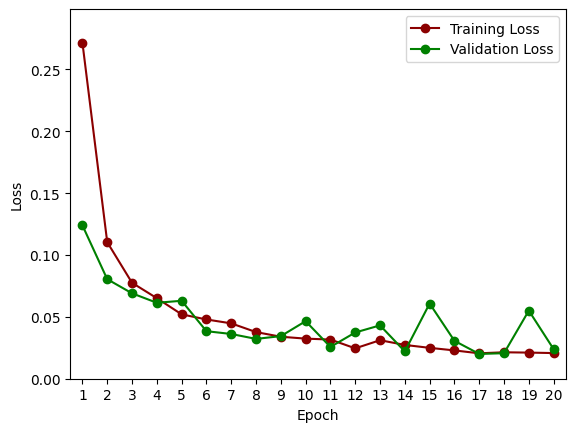

In [327]:
# plot training and validation losses as a function of epoch
# data is in 3 lists, each with 20 elements

# figure out the maximum loss from both lists
all_losses = train_losses + val_losses # get all losses in one list
max_loss = max(all_losses) # find the max value
# upper limit on the y axis
upper_y = max_loss * 1.1

plt.figure() # new figure

# plot the training and validation losses
plt.plot(ep, train_losses, '-o', c='darkred', label="Training Loss");
plt.plot(ep, val_losses, '-o', c='green', label="Validation Loss");

# format axes so the plot is neater
plt.xlim(0.5, 20.5)
plt.xticks(range(1,21)) # ticks at each epoch (1-20)
plt.ylim(0, upper_y)

# add labels and a legend
plt.xlabel("Epoch");
plt.ylabel("Loss");
plt.legend();

plt.show() # display figure

__What do these loss curves tell us?__

* Both losses decrease over time, so the network is definitely learning - the learning rate is on the correct scale.

These loss curves are fairly positive. Both losses are decreasing, so the network is definitely learning, i.e. the learning rate is on the correct scale. The training loss is smooth with no sharp jumps, and is decreasing steadily. 

We always expect the training loss to be lower than the validation loss, as the optimisation is based on the training data. If the validation curve were increasing, this would be an indicator of overfitting.

- more stuff here

This loss curve is "healthy" enough to indicate that the architecture of the network does not need to be changed any more.



### Plot Accuracy by Epoch

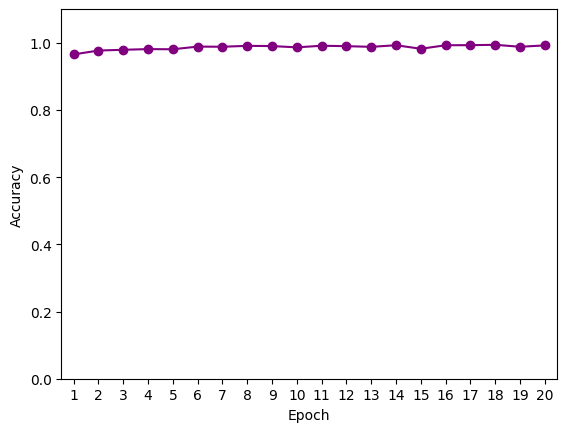

In [333]:
# plot accuracy as a function of epoch
# data is in 2 lists, each with 20 elements

plt.figure() # new figure

# plot the accuracy
plt.plot(ep, accs, '-o', c='purple');

# format axes
plt.xlim(0.5, 20.5)
plt.xticks(range(1,21)) # ticks at each epoch (1-20)
plt.ylim(0, 1.1) # change lower limit for better resolution

# add labels and a legend
plt.xlabel("Epoch");
plt.ylabel("Accuracy");

plt.show() # display figure

__What does the accuracy curve tell us?__

* In a binary classification problem, accuracy is not the best indicator of model performance, but it can still be useful to see how it varies over the course of the training loop.

### Plot ROC-AUC Score by Epoch

ROC-AUC = Area Under the Receiver Operating Characteristic Curve.

This is a useful metric for classification problems. It assigns a score between 0.5 and 1 for each set of predictions for the validation data.


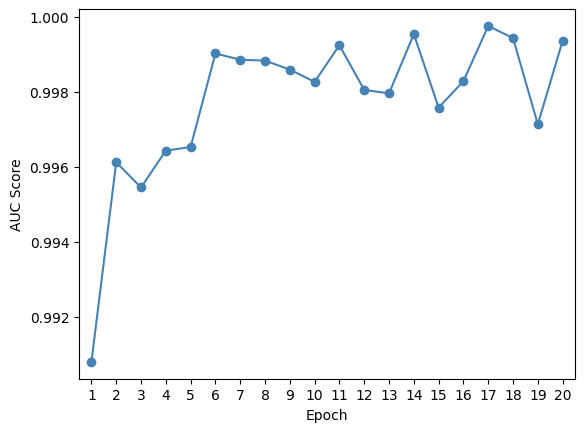

In [336]:
# plot auc score as a function of epoch

plt.figure() # new figure

# plot the auc score
plt.plot(ep, roc_aucs, '-o', c='steelblue');

# format axes so the plot is neater
plt.xlim(0.5, 20.5)
plt.xticks(range(1,21)) # ticks at each epoch (1-20)
#plt.ylim(0.5, 1) # uncomment to see full range (lower resolution)

# add labels and a legend
plt.xlabel("Epoch");
plt.ylabel("AUC Score");

plt.show() # display figure

__What does the ROC-AUC curve tell us?__

* Both losses decrease over time, so the network is definitely learning - the learning rate is on the correct scale.

__What does this curve tell us?__

* stuff

## 
> ## Evaluate Performance Using Testing Data

### Classification of Test Data Using Model

At the end of the diagnostic and model tuning loop, the model parameters have been optimised. The final test of the model is to check its predictions for completely unknown data. The test data has not been used to train or tune the model, so it has not yet been "seen" by the network.

In [337]:
# run through test data once
# compare model predictions to true labels

# set model to evaluation mode
pc_model.eval()

# define total test loss
total_loss = 0
# total number of correct predictions
total_correct = 0

# define empty lists for computing roc_auc_score
all_probs = [] # probabilities
all_preds = [] # predicted labels
all_labels = [] # true labels

# don't need to calculate gradients
# so we can run this more efficiently
with torch.no_grad():
        
    # loop through batches of the test data
    for X_test_batch, y_test_batch in test_loader:

        # for each batch of test data

        # push to the gpu if available
        X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)

        # predict y values for validation data
        # we are not using the loss function here
        # so we need to implement the sigmoid ourselves

        # forward pass on validation data
        y_logits = pc_model(X_test_batch)
        # pass logits from model through sigmoid
        y_probs = torch.sigmoid(y_logits)
        # this is now a value between 0 and 1
        # round to the nearest integer to get the label (0 or 1)
        y_preds = torch.round(y_probs)

        # calculate losses on testing data
        # and add to total loss       
        y_loss = loss_fn(y_logits, y_test_batch)
        total_loss += y_loss.item()*len(X_test_batch)
                
        # calculate accuracy of predictions
        # add this to total number of correct predictions
        correct = torch.eq(y_test_batch, y_preds).sum().item()
        total_correct += correct

        # save probabilities and labels for evaluation metrics
        # keep variables from each batch
        # sklearn cannot access gpu - move to the cpu first
        all_probs.append(y_probs.cpu())
        all_preds.append(y_preds.cpu())
        all_labels.append(y_test_batch.cpu())

    # looped through all batches of the test data

# average test loss
# divide by number of samples
test_loss = total_loss / len(test_set)

# fraction of predictions that are correct
test_acc = (total_correct / len(test_set))
    
# concatenate lists of tensors into single tensors
# then convert to numpy arrays
all_y_probs = torch.cat(all_probs).numpy()
all_y_preds = torch.cat(all_preds).numpy()
all_y_labels = torch.cat(all_labels).numpy()

### Print Evaluation Metrics

__Test Loss__

Calculated by the loss function.

In [338]:
# average test loss calculated above
# print the result
print("Test Loss:")
print(test_loss)

Test Loss:
0.028236201568040995


__Test Accuracy__

Fraction of predictions that match the true value.

In [339]:
# total accuracy calculated above
# print the result
print("Test Accuracy:")
print(test_acc)

Test Accuracy:
0.99225


__ROC-AUC Score__

Description of AUC Score

In [340]:
# calculate roc_auc
y_auc = metrics.roc_auc_score(all_y_labels, all_y_probs)

# print the result
print("ROC-AUC Score:")
print(y_auc)

ROC-AUC Score:
0.9987617500000001


__F1 Score__

Description of F1 score.

In [341]:
# calculate F1 score
y_f1 = metrics.f1_score(all_y_labels, all_y_preds)

# print the result
print("F1 Score:")
print(y_f1)

F1 Score:
0.9922012578616353


__Confusion Matrix__

Description of confusion matrix

Confusion Matrix:


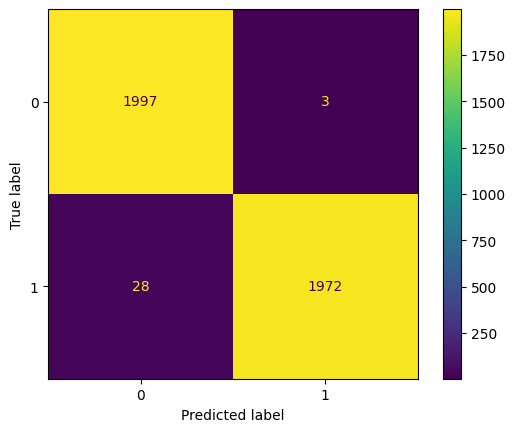

In [342]:
# compute the confusion matrix
con_mat = metrics.confusion_matrix(all_y_labels, all_y_preds)

# display the confusion matrix
print("Confusion Matrix:")
cm_vis = metrics.ConfusionMatrixDisplay(con_mat)
cm_vis.plot();

__Classification Report__

Describe what this is

In [343]:
# generate the classification report
# contains precision and recall for each class
y_cr = metrics.classification_report(all_y_labels, all_y_preds)

# print the report
print("Classification Report:")
print(y_cr)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2000
         1.0       1.00      0.99      0.99      2000

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



### Discussion of Test Results

* Average Loss:
* Test Accuracy:
* ROC-AUC Score:
* Precision and Recall:
* F1 Score:
* Confusion Matrix:
* Classification Report:

## 
> ## Resources

### Sources Used for Q2 Notebook

* https://codesignal.com/learn/courses/introduction-to-pytorch-tensors/lessons/defining-a-dataset-with-pytorch-tensors
* https://discuss.pytorch.org/t/pytorch-torch-no-grad-vs-torch-inference-mode/134099?u=timgianitsos
* https://discuss.pytorch.org/t/what-do-tensordataset-and-dataloader-do/107017
* https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
* https://docs.pytorch.org/docs/stable/generated/torch.eq.html
* https://docs.pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
* https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
* https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html
* https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html
* https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html
* https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html
* https://docs.pytorch.org/docs/stable/generated/torch.round.html
* https://docs.pytorch.org/docs/stable/nn.html
* https://docs.pytorch.org/docs/stable/nn.html
* https://docs.pytorch.org/docs/stable/optim.html
* https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://docs.pytorch.org/tutorials/beginner/data_loading_tutorial.html
* https://machinelearningmastery.com/activation-functions-in-pytorch/
* https://medium.com/@noel.benji/breaking-down-backpropagation-in-pytorch-3762ea107d3a
* https://medium.com/@sahin.samia/train-a-neural-network-in-pytorch-a-complete-beginners-walkthrough-3897d18d6078
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dtypes.html
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.values.html
* https://playground.tensorflow.org/
* https://realpython.com/ref/glossary/subclass/
* https://saturncloud.io/blog/how-do-i-convert-a-pandas-dataframe-to-a-pytorch-tensor/
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix_at_thresholds.html
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
* https://scikit-learn.org/stable/modules/preprocessing.html
* https://stackoverflow.com/questions/2709821/what-is-the-purpose-of-the-self-parameter-why-is-it-needed
* https://stackoverflow.com/questions/8609153/why-do-we-use-init-in-python-classes
* https://stackoverflow.com/questions/50935345/understanding-torch-nn-parameter
* https://stackoverflow.com/questions/75979632/pytorchs-nn-bcewithlogitsloss-behaves-totaly-differently-than-nn-bceloss
* https://www.geeksforgeeks.org/deep-learning/converting-a-pandas-dataframe-to-a-pytorch-tensor/
* https://www.geeksforgeeks.org/deep-learning/understanding-the-forward-function-output-in-pytorch/
* https://www.geeksforgeeks.org/pandas/adding-new-column-to-existing-dataframe-in-pandas/
* https://www.geeksforgeeks.org/python/activation-functions-in-pytorch/
* https://www.geeksforgeeks.org/python/how-to-join-tensors-in-pytorch/
* https://www.learnpytorch.io/00_pytorch_fundamentals/
* https://www.learnpytorch.io/01_pytorch_workflow/
* https://www.learnpytorch.io/02_pytorch_classification/
* https://www.reddit.com/r/learnmachinelearning/comments/vogqe5/is_validation_dataset_really_a_must/?rdt=44162
* https://www.w3schools.com/python/python_classes.asp
* https://www.w3schools.com/python/python_ml_auc_roc.asp